# 05 - Quick DistilBERT Fine-Tuning

We fine-tune only the classification head on a small sample (5 000 reviews) for 2 epochs:

1. Load & sample SP splits, clean text  
2. Build HF `Dataset`s  
3. Tokenize (max_length=64)  
4. Load & freeze DistilBERT backbone  
5. Define metrics & training arguments  
6. Train with `Trainer` (1–2 epochs, fp16)  
7. Evaluate on test set  
8. Save model & tokenizer  


In [1]:
!pip install --quiet transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [6]:

import os, re, math, random, json
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, accuracy_score
)

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, set_seed
)
from transformers.trainer_utils import get_last_checkpoint


In [7]:
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# --------------------------
# Paths & config
# --------------------------
# Try a few likely locations for project_splits (matches your screenshot)
CANDIDATES = [
    "/content/drive/project_splits",
    "/content/drive/MyDrive/project_splits",
    "/content/drive/MyDrive/fake-review-detector/project_splits",
    "project_splits",
]
for p in CANDIDATES:
    if os.path.isdir(p):
        PROJECT_SPLITS_DIR = p
        break
else:
    raise FileNotFoundError("Could not find project_splits folder. Please update CANDIDATES.")

# Where to save models/plots (in Drive so you survive restarts)
if IN_COLAB:
    BASE_SAVE = "/content/drive/MyDrive/fake-review-detector"
else:
    BASE_SAVE = "./"
OUTPUT_DIR = os.path.join(BASE_SAVE, "models", "distilbert_mix_from_splits_10k")
PLOTS_DIR  = os.path.join(OUTPUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

MODEL_NAME     = "distilbert-base-uncased"
SEED           = 42
MAX_LEN        = 64
BATCH_SIZE     = 64
NUM_EPOCHS     = 3
LEARNING_RATE  = 3e-5      # a bit conservative when unfreezing layers
SAMPLE_TOTAL   = 10_000

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)
print("PROJECT_SPLITS_DIR:", PROJECT_SPLITS_DIR)
print("Saving to:", OUTPUT_DIR)


DEVICE: cpu
PROJECT_SPLITS_DIR: project_splits
Saving to: /content/drive/MyDrive/fake-review-detector/models/distilbert_mix_from_splits_10k


In [9]:
# --------------------------
# Utils
# --------------------------
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)                 # HTML
    s = re.sub(r"http\S+|www\.\S+", " ", s)        # URLs
    s = re.sub(r"[^a-z\s]", " ", s)                # keep letters/spaces only
    s = re.sub(r"\s+", " ", s).strip()
    return s

def add_key(df):
    """Add a stable 'key' to merge rows across splits.
       Prefer 'Id' if present; else build from (UserId, ProductId, Time) if available;
       else fall back to index (least ideal)."""
    if "Id" in df.columns:
        df["key"] = df["Id"].astype(str)
    elif {"UserId","ProductId","Time"}.issubset(df.columns):
        df["key"] = (
            df["UserId"].astype(str) + "|" +
            df["ProductId"].astype(str) + "|" +
            df["Time"].astype(str)
        )
    else:
        df["key"] = df.index.astype(str)
    return df

def load_split(file_name, label_col_name):
    """Load a heuristic split CSV with at least: Text, label (0/1), and some id columns."""
    path = os.path.join(PROJECT_SPLITS_DIR, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing split file: {path}")
    df = pd.read_csv(path)
    # normalize column names
    # raw may be 'Summary'+'Text'; we use 'Text' if present
    if "Text" not in df.columns:
        # if a cleaned text exists, use it; otherwise try Summary+Text fallback
        if "cleaned" in df.columns:
            df["Text"] = df["cleaned"].astype(str)
        elif "Summary" in df.columns:
            df["Text"] = (df["Summary"].astype(str) + " " + df["Text"].astype(str)).str.strip()
        else:
            raise ValueError(f"{file_name} does not contain a 'Text' (or 'cleaned') column.")
    # must have a 'label' column
    if "label" not in df.columns:
        raise ValueError(f"{file_name} must contain a 'label' column (0=fake,1=genuine).")
    df = add_key(df)
    df = df[["key","Text","label"]].rename(columns={"label":label_col_name})
    return df


In [10]:
# --------------------------
# 1) Load HH / SP / BD *train* splits
# --------------------------
sp = load_split("sp_train.csv", "label_sp")
hh = load_split("hh_train.csv", "label_hh")
bd = load_split("bd_train.csv", "label_bd")

# (Optional) If you prefer the already-cleaned versions:
# sp = load_split("sp_train_clean.csv", "label_sp")
# hh = load_split("hh_train_clean.csv", "label_hh")
# bd = load_split("bd_train_clean.csv", "label_bd")

# --------------------------
# 2) Merge into one table and clean text
# --------------------------
mix = sp.merge(hh, on="key", how="outer").merge(bd, on="key", how="outer")

# pick one text column (prefer sp->hh->bd)
def choose_text(row):
    for col in ["Text_x", "Text_y", "Text"]:
        if col in row and isinstance(row[col], str) and len(row[col].strip()) > 0:
            return row[col]
    return ""

mix["text"] = mix.apply(choose_text, axis=1).astype(str).apply(clean_text)
mix = mix.drop(columns=[c for c in mix.columns if c.startswith("Text")])

# --------------------------
# 3) Majority vote mixture label
# --------------------------
def majority_vote(row):
    votes = []
    for col in ("label_sp","label_hh","label_bd"):
        v = row.get(col, np.nan)
        if pd.notna(v):
            votes.append(int(v))
    if not votes:
        return np.nan, 0
    c0 = votes.count(0)
    c1 = votes.count(1)
    if c0 == c1:
        return np.nan, len(votes)  # tie -> ignore in high-confidence set
    return (0 if c0 > c1 else 1), len(votes)

lab, n_votes = zip(*mix.apply(majority_vote, axis=1))
mix["label"]   = lab
mix["n_votes"] = n_votes
mix = mix.dropna(subset=["label"]).reset_index(drop=True)
mix["label"] = mix["label"].astype(int)

# High-confidence (>=2 agreeing votes)
hi = mix[mix["n_votes"] >= 2].copy()
print("High-confidence pool:", hi.shape, "\n", hi["label"].value_counts())

# If fewer than 10k, top-up with single-vote rows
needed = max(0, SAMPLE_TOTAL - len(hi))
if needed > 0:
    lo = mix[mix["n_votes"] == 1].copy()
    if len(lo) > 0:
        # keep class balance reasonable in top-up
        per = needed // 2
        add = []
        for cls in [0,1]:
            sub = lo[lo["label"]==cls]
            if len(sub) > 0:
                k = min(per, len(sub))
                add.append(sub.sample(n=k, random_state=SEED))
        add_df = pd.concat(add, axis=0) if add else pd.DataFrame(columns=lo.columns)
        hi = pd.concat([hi, add_df], axis=0).drop_duplicates(subset=["key"]).reset_index(drop=True)

# Final pool (may be > 10k; downsample stratified)
pool = hi[["text","label"]].copy()

def stratified_sample(df, n_total=10_000, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    half = n_total // 2
    for c in [0,1]:
        sub = df[df["label"]==c]
        k = min(len(sub), half)
        if k > 0:
            out.append(sub.sample(n=k, random_state=seed))
    out = pd.concat(out, axis=0) if out else df.head(0)
    if len(out) < n_total:
        # top-up from the larger class
        counts = df["label"].value_counts()
        more = 1 if counts.get(1,0) >= counts.get(0,0) else 0
        rem = n_total - len(out)
        topup = df[df["label"]==more].drop(index=out.index, errors="ignore")
        if len(topup) > 0:
            out = pd.concat([out, topup.sample(n=min(rem, len(topup)), random_state=seed)], axis=0)
    return out.sample(frac=1.0, random_state=seed).reset_index(drop=True)[:n_total]

dataset_df = stratified_sample(pool, SAMPLE_TOTAL, SEED)
print("Mixture sample:", dataset_df.shape, "\n", dataset_df["label"].value_counts())


High-confidence pool: (112107, 7) 
 label
1    102562
0      9545
Name: count, dtype: int64
Mixture sample: (10000, 2) 
 label
1    5000
0    5000
Name: count, dtype: int64


In [11]:
# --------------------------
# 4) Split 80/10/10
# --------------------------
n = len(dataset_df)
i_train = int(0.8*n)
i_val   = int(0.9*n)
train_df = dataset_df.iloc[:i_train].reset_index(drop=True)
val_df   = dataset_df.iloc[i_train:i_val].reset_index(drop=True)
test_df  = dataset_df.iloc[i_val:].reset_index(drop=True)
print("Splits:", train_df.shape, val_df.shape, test_df.shape)

Splits: (8000, 2) (1000, 2) (1000, 2)


In [12]:
# --------------------------
# 5) Tokenize (max_length=64)
# --------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=MAX_LEN)

hf_train = Dataset.from_pandas(train_df).map(tok_fn, batched=True).remove_columns(["text"])
hf_val   = Dataset.from_pandas(val_df).map(tok_fn, batched=True).remove_columns(["text"])
hf_test  = Dataset.from_pandas(test_df).map(tok_fn, batched=True).remove_columns(["text"])

hf_train = hf_train.with_format("torch", columns=["input_ids","attention_mask","label"])
hf_val   = hf_val.with_format("torch", columns=["input_ids","attention_mask","label"])
hf_test  = hf_test.with_format("torch", columns=["input_ids","attention_mask","label"])

collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
# --------------------------
# 6) Load model & unfreeze last two layers + head
# --------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Freeze all
for p in model.parameters():
    p.requires_grad = False

# Unfreeze DistilBERT layers 4 & 5
for name, p in model.named_parameters():
    if "distilbert.transformer.layer.4" in name or "distilbert.transformer.layer.5" in name:
        p.requires_grad = True

# Unfreeze classification head
for sub in ("pre_classifier", "classifier"):
    for p in getattr(model, sub).parameters():
        p.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.2f}% trainable)")
model.to(DEVICE)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 14,767,874 / 66,955,010 (22.06% trainable)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [14]:
# --------------------------
# 7) Metrics
# --------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy"      : accuracy_score(labels, preds),
        "f1"            : f1_score(labels, preds, average="weighted", zero_division=0),
        "precision"     : precision_score(labels, preds, average="weighted", zero_division=0),
        "recall"        : recall_score(labels, preds, average="weighted", zero_division=0),
        "f1_fake"       : f1_score(labels, preds, average="binary", pos_label=0, zero_division=0),
        "precision_fake": precision_score(labels, preds, average="binary", pos_label=0, zero_division=0),
        "recall_fake"   : recall_score(labels, preds, average="binary", pos_label=0, zero_division=0),
    }

In [15]:
# --------------------------
# 8) TrainingArguments (Transformers 4.54.0 API)
# --------------------------
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_fake",
    greater_is_better=True,
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    logging_steps=100,
    save_total_limit=2,
    report_to="none",
    fp16=torch.cuda.is_available(),
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    data_collator=collator,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    compute_metrics=compute_metrics,
)

# Auto-resume if a checkpoint exists
resume_ckpt = get_last_checkpoint(OUTPUT_DIR) if os.path.isdir(OUTPUT_DIR) else None
if resume_ckpt:
    print("Resuming from:", resume_ckpt)

trainer.train(resume_from_checkpoint=resume_ckpt)


/tmp/ipython-input-3076074063.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Fake,Precision Fake,Recall Fake
1,0.494400,0.338205,0.853000,0.852788,0.854922,0.853000,0.847034,0.880952,0.815631
2,0.342500,0.295531,0.878000,0.877990,0.878093,0.878000,0.876768,0.883910,0.869739
3,0.322100,0.280253,0.885000,0.885000,0.885001,0.885000,0.884654,0.885542,0.883768


TrainOutput(global_step=375, training_loss=0.3676824951171875, metrics={'train_runtime': 4507.1605, 'train_samples_per_second': 5.325, 'train_steps_per_second': 0.083, 'total_flos': 397402195968000.0, 'train_loss': 0.3676824951171875, 'epoch': 3.0})

Test metrics: {'eval_loss': 0.33244529366493225, 'eval_accuracy': 0.862, 'eval_f1': 0.8620430851255448, 'eval_precision': 0.8623344335489755, 'eval_recall': 0.862, 'eval_f1_fake': 0.8583162217659137, 'eval_precision_fake': 0.847870182555781, 'eval_recall_fake': 0.8690228690228691, 'eval_runtime': 101.9528, 'eval_samples_per_second': 9.808, 'eval_steps_per_second': 0.157, 'epoch': 3.0}
              precision    recall  f1-score   support

           0      0.848     0.869     0.858       481
           1      0.876     0.855     0.865       519

    accuracy                          0.862      1000
   macro avg      0.862     0.862     0.862      1000
weighted avg      0.862     0.862     0.862      1000



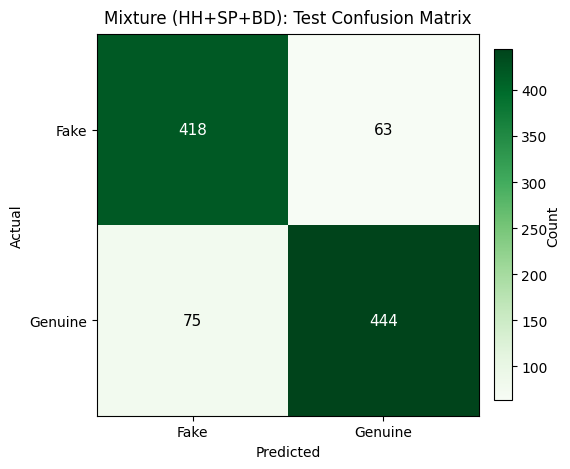

Saved to: /content/drive/MyDrive/fake-review-detector/models/distilbert_mix_from_splits_10k/plots/confusion_matrix_mix_from_splits.png


In [19]:
# --------------------------
# 9) Evaluate & plot confusion matrix (clean layout)
# --------------------------
test_metrics = trainer.evaluate(hf_test)
print("Test metrics:", test_metrics)

pred = trainer.predict(hf_test)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)
print(classification_report(y_true, y_pred, digits=3))

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os

cm = confusion_matrix(y_true, y_pred)

# Use constrained layout so the colorbar never overlaps the title
fig, ax = plt.subplots(figsize=(5.6, 5.2), constrained_layout=True)

im = ax.imshow(cm, cmap="Greens")  # keep your colormap
cbar = fig.colorbar(im, ax=ax, location="right", fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=90, va="center")

ax.set_xticks([0, 1], labels=["Fake", "Genuine"])
ax.set_yticks([0, 1], labels=["Fake", "Genuine"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Mixture (HH+SP+BD): Test Confusion Matrix", pad=8)  # add title padding
ax.set_aspect("equal")

# value labels
for i in range(2):
    for j in range(2):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j, i, f"{cm[i, j]:,}", ha="center", va="center", fontsize=11, color=color)

# crisper save
os.makedirs(PLOTS_DIR, exist_ok=True)
out_path = os.path.join(PLOTS_DIR, "confusion_matrix_mix_from_splits.png")
fig.savefig(out_path, dpi=300)   # higher DPI
plt.show()
print("Saved to:", out_path)


In [17]:
# --------------------------
# 10) Save final model & tokenizer
# --------------------------
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Saved to:", OUTPUT_DIR)

Saved to: /content/drive/MyDrive/fake-review-detector/models/distilbert_mix_from_splits_10k


In [18]:
save_dir = "models/distilbert_mix_from_splits_10k"
trainer.save_model(save_dir)            # saves model + config
tokenizer.save_pretrained(save_dir)     # saves tokenizer
print("Saved:", save_dir)


Saved: models/distilbert_mix_from_splits_10k
